## Stochastic, spatially-explicit SEIR2 model with seasonal variation and age groups 

1. CREATING THE OD MATRIX FOR BELGIAN DISTRICTS (43)
2.  (for later) CREATING THE SOCIAL CONTACTS MATRIX FOR EACH AGE GROUP 
3. GETTING THE DEMOGRAPHIC INFO OF PEOPLE PER DISTRIC - and age-group 
4. LOADING THE SEIR2 MODEL
5. USING THE OD MATRIX TO REPRESENT DISEASE DYNAMICS IN SPATIALLY EXPLICIT MANER 

In [1]:
# import dependencies

import pandas as pd
import numpy as np
import csv
import geopandas as gpd
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors



In [2]:
###############################
## 1. CREATING THE OD MATRIX ##
###############################

# 1.1 loading the mobility data

# I have 14 files with 1 day mobility data that I need to average over time
import glob
# Specify the path to the directory containing your CSV files
csv_files_path = '/home/rita/PyProjects/Practice/Spatially-explicit SIR model/mobdata/*.csv'

# Use the glob module to get a list of all CSV files in the specified path
csv_files = glob.glob(csv_files_path)

# Initialize an empty list to store DataFrames from each CSV file
dataframes = []

# Loop through the list of CSV files and read each file into a DataFrame
for csv_file in csv_files:
    df = pd.read_csv(csv_file) # I want to remove the first row and column from my dataframe 
    dataframes.append(df)

# concatenate the list of dfs into a single df
combined_df = pd.concat(dataframes, ignore_index=True)
average_df = combined_df.groupby('mllp_postalcode', as_index= False).mean()

#this is now my OD matrix for one standard day:
ODmatrix = average_df
# print(ODmatrix) # I want to remove the abroad column and the foreigner row 
ODmatrixx = ODmatrix.iloc[:-1, :-1]

# print("New OD matrix:" ,ODmatrixx) #OK
ODmatrix = ODmatrixx

# I set this first column to names: 
ODmatrix.set_index('mllp_postalcode', inplace=True) # now my OD matrix is a 43 x 43

print(str(ODmatrix), type(ODmatrix)) #[43 rows x 43 columns] <class 'pandas.core.frame.DataFrame'>

                    11000     12000     13000     21000     23000     24000  \
mllp_postalcode                                                               
11000            0.907668  0.017482  0.011743  0.006954  0.007673  0.005690   
12000            0.054619  0.822509  0.015239  0.012735  0.023885  0.024053   
13000            0.032686  0.013118  0.884876  0.003587  0.004881  0.015349   
21000            0.003285  0.001787  0.001041  0.897564  0.039124  0.005228   
23000            0.007327  0.010966  0.002156  0.104044  0.779450  0.015238   
24000            0.009977  0.015757  0.009147  0.026770  0.029043  0.837363   
25000            0.002331  0.000952  0.000814  0.057851  0.022149  0.009447   
31000            0.004876  0.001421  0.001852  0.005286  0.004823  0.002870   
32000            0.004042  0.001320  0.001745  0.002631  0.004091  0.002448   
33000            0.003305  0.000991  0.001377  0.002541  0.003600  0.002182   
34000            0.004282  0.001297  0.001716  0.003

My OD matrix a 43 x 43 matrix, which will be the same for every age group

In [3]:
#######################################
# 2. DOWNLOADING THE DEMOGRAPHY DATA ##
#######################################

df_age = pd.read_csv("/home/rita/PyProjects/Practice/Spatially-explicit SIR model/age_structure_per_arr.csv")
# print(df_age)
# print(type(df_age))

# I need to divide this into the age-groups used in the SEIR2 model: 
age_groups = pd.IntervalIndex.from_tuples([(0,5),(5,15),(15,65),(65,120)], closed='left')

# Categorize ages into age groups - create a new variable
df_age['age_group'] = pd.cut(df_age['age'], bins=age_groups)
# print(df_age)

# Group by location and age group, then sum the counts
grouped_df = df_age.groupby(['NIS', 'age_group']).agg({'number': 'sum'}).reset_index()
# print(grouped_df) # final dataframe has 172 rows ( = 43 districts x 4 agegroups)

# I need to change the age group into a new dimension so that I obtain a matrix of 43x1 for every one of the 4 age groups 
# Pivot the DataFrame to have age groups as columns, locations as rows, and counts as values
pivot_df = grouped_df.pivot(index='NIS', columns='age_group', values='number').fillna(0)
locations = pivot_df.index.values # save location names

# Set location names as row names
pivot_df.index = locations
# print("pivot_df", pivot_df) # now each age-group is represented by a different column

# Convert pivot_df to ndarray
ndarray_2d = pivot_df.to_numpy()
# Create structured ndarray with location names as row names
dtype = [('location', 'U20')] + [(str(age_group), 'int') for age_group in pivot_df.columns]
structured_ndarray = np.empty(len(locations), dtype=dtype)

# Fill structured ndarray with location names and counts
structured_ndarray['location'] = locations
for i, age_group in enumerate(pivot_df.columns):
    structured_ndarray[str(age_group)] = ndarray_2d[:, i]

# print("Structured ndarray with Location Names as Row Names:")
# print(structured_ndarray)

print("Structure (Shape) of ndarray_2d:", ndarray_2d.shape)
print("Type of ndarray_2d:", ndarray_2d.dtype)

# #OK, this is my starting population at the beginning of the epidemic for every age group
sum_per_location = ndarray_2d

Structure (Shape) of ndarray_2d: (43, 4)
Type of ndarray_2d: int64


/tmp/ipykernel_8126/1675251789.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df_age.groupby(['NIS', 'age_group']).agg({'number': 'sum'}).reset_index()


In [4]:
############################################################
# redistributing the people accoring to the OD matrix
############################################################

# This is the sum_per_location matrix x the OD matrix:

###################################
####### OD x population #######
###################################
ODmatrixT = np.transpose(ODmatrix)
# print("ODmatrix:", ODmatrix)
# print("ODmatrixT:", ODmatrixT)

ODmatrixT_ndarray = ODmatrixT.values
print(type(ODmatrixT_ndarray)) #<class 'numpy.ndarray'>
print("Shape ODmatrixT_ndarray", ODmatrixT_ndarray.shape)

sum_per_location_array = np.array(sum_per_location)
print("type sum_per_location", type(sum_per_location_array))   #<class 'numpy.ndarray'>
print("shape sum_per_location", sum_per_location_array.shape) #(43, 4)


# Now I mulitply the ODmatrixT with every age-group in the demographic data: 

# Create an empty list to store the results for each age group
result_matrices = []

# Loop over each age group in sum_per_location
for age_group_column in sum_per_location.T:  # Transpose to loop over columns

    # print("age_group_column", age_group_column)
    # print("shape age_group_column", age_group_column.shape)
    # print("shape ODmatrixT_ndarray", ODmatrixT_ndarray.shape)

    # Perform element-wise multiplication between ODmatrixT_ndarray and the current age group column
    result_matrix = ODmatrixT_ndarray @ age_group_column  # ndarray (43,)
    
    # Append the result to the list
    result_matrices.append(result_matrix) # list of 4 arrays

# Convert the list of result matrices to a numpy array
distr_new = np.array(result_matrices)
print("Shape distr_new", distr_new.shape) # (4, 43)

#print(distr_new)

<class 'numpy.ndarray'>
Shape ODmatrixT_ndarray (43, 43)
type sum_per_location <class 'numpy.ndarray'>
shape sum_per_location (43, 4)
Shape distr_new (4, 43)


We will now set up the model with an additional dimension for space  
These models are based on TWA's COVID-19 models in https://github.com/UGentBiomath/COVID19-Model/blob/master/src/covid19_DTM/models/SDE_models.py

In [5]:
################
## Load model ##
################

from DENV_models_pySODM import JumpProcess_SEIR2_spatial_stochastic as DENV_spat_stoch_SEIR2

In [6]:
#################
## Setup model ##
#################
# p = (273-181)/365
p = 0
# Define model parameters
params = {'alpha': 45 ,'sigma':5, 'gamma': 15, 'psi': 1.5, 'beta_0' : np.array([0.2, 0.15, 0.10, 0.05]), 'beta_1' : 0.5, 'ph':p, "ODmatrix": ODmatrix} # I made younger groups more infectious than older, beta_1 is the same for all age groups

# Define initial condition
age_groups = pd.IntervalIndex.from_tuples([(0,5),(5,15),(15,65),(65,120)], closed='left')
locations = df_age["NIS"].unique()

Tau = 0.5
time = list(np.arange(0, 3*365, Tau))

# Using the hardcode Belgian demographics 
# Create a MultiIndex combining age groups and locations
multi_index = pd.MultiIndex.from_product([age_groups, locations], names=['age_group', 'NIS'])

# Flatten the sum_per_location array to match the MultiIndex
flattened_values = sum_per_location.flatten()

# Create initN Series with the MultiIndex and flattened values
initN = pd.Series(index=multi_index, data=flattened_values) # (172,)

initN_df = initN.unstack(level='age_group') # (43,4)
initN_df.columns.name = 'age_group' 
initN_df.index.name = 'NIS'
print("Shape of initN_df:", initN_df.shape) #(43, 4)


max_infected = initN_df * 0.0001 #max possible infected at start of the epidemic = 0.01% of population per age-group
print("shape max_infected", max_infected.shape) #(43, 4)

# Generate random samples from uniform distribution between 0 and 1,shape is determined by max_infected.shape x values in max_infected
random_samples = np.random.rand(*max_infected.shape) * max_infected.values #nd_array (43,4)

# Create initI1 DataFrame with the same index and columns as max_infected
initI1 = pd.DataFrame(random_samples, index=max_infected.index, columns=max_infected.columns)

# Now initI1 has the shape (43, 4) matching max_infected
print("Shape of initI1:", initI1.shape)


#select random samples again for initI2
random_samples = np.random.rand(*max_infected.shape) * max_infected.values
initI2 = pd.DataFrame(random_samples, index=max_infected.index, columns=max_infected.columns)
print("Shape of initI2:", initI2.shape)


initS = initN_df - initI1 - initI2
print("Shape of initS:", initS.shape)

initI_cum = initI1 + initI2

init_states = {'S': initS, #DataFrame (43,4)
               'I1': initI1,
               'I2': initI2, 
               'I_cum' : initI_cum}

# Define model coordinates
coordinates={'NIS' : locations,'age_group': age_groups} #locations = ndarray (43,), agegroups = IntervalIndex 4

Shape of initN_df: (43, 4)
shape max_infected (43, 4)
Shape of initI1: (43, 4)
Shape of initI2: (43, 4)
Shape of initS: (43, 4)


In [7]:
####################
# Initialize model #
####################

model_SEIR2_SF = DENV_spat_stoch_SEIR2(states=init_states, parameters=params, coordinates=coordinates) 

In [8]:
######################
# simulate the model #
######################
tau = 0.5
n = 1   # Repeated simulations used in visualisations - not used at the moment = 1
out = model_SEIR2_SF.sim(time=5*365, samples={}, N =n ,tau=tau, output_timestep=1)
#  Can change the values of model parameters at every repeated simulation by drawing samples from a dictionary `samples` using a function `draw_function`
print(out)
# print(out.indexes['age_group'].unique())

<xarray.Dataset> Size: 38MB
Dimensions:    (time: 1826, NIS: 43, age_group: 4)
Coordinates:
  * time       (time) int64 15kB 0 1 2 3 4 5 6 ... 1820 1821 1822 1823 1824 1825
  * NIS        (NIS) int64 344B 11000 12000 13000 21000 ... 91000 92000 93000
  * age_group  (age_group) object 32B [0, 5) [5, 15) [15, 65) [65, 120)
Data variables: (12/15)
    S          (time, NIS, age_group) float64 3MB 6.119e+04 ... 1.27e+04
    S1         (time, NIS, age_group) float64 3MB 0.0 0.0 ... 3.903e+03 372.0
    S2         (time, NIS, age_group) float64 3MB 0.0 0.0 ... 4.163e+03 277.0
    E1         (time, NIS, age_group) float64 3MB 0.0 0.0 0.0 ... 0.0 0.0 1.0
    E2         (time, NIS, age_group) float64 3MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    E12        (time, NIS, age_group) float64 3MB 0.0 0.0 0.0 ... 0.0 1.0 0.0
    ...         ...
    I12        (time, NIS, age_group) float64 3MB 0.0 0.0 0.0 ... 0.0 3.0 0.0
    I21        (time, NIS, age_group) float64 3MB 0.0 0.0 0.0 ... 0.0 1.0 0.0
    R1        

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


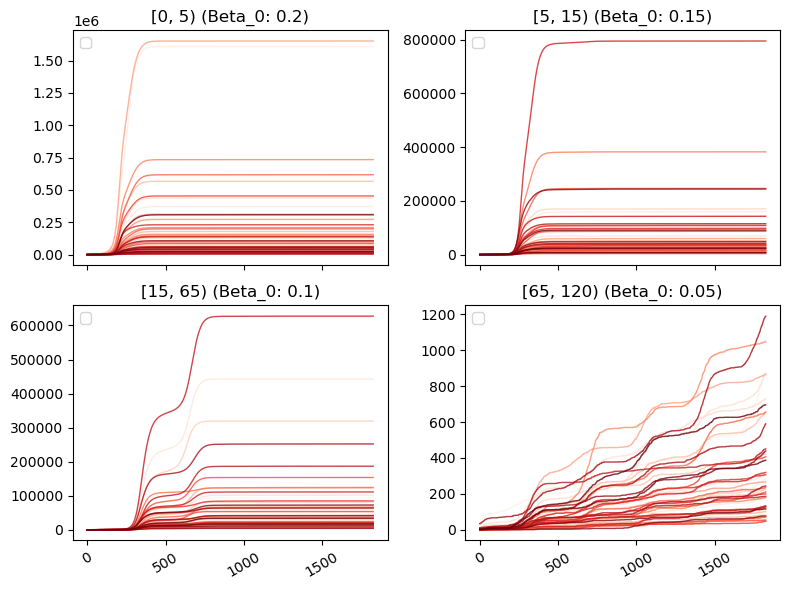

In [9]:
## Look into the output: 

# cummulative I over time: 

unique_age_groups = out.indexes['age_group'].unique()
unique_locations = out.indexes['NIS'].unique()

# # defining various shades of blue for districs (locations)
# colors = plt.cm.Blues(np.linspace(0, 1, len(unique_locations)))  # Generate different shades of blue

# Generate a list of shades of blue for each location
colors = plt.cm.Reds(np.linspace(0, 1, 43))  # Generate different shades of blue for 43 locations
colors_dict = {location: color for location, color in zip(unique_locations, colors)}

fig, axs = plt.subplots(2, 2, sharex=True, figsize=(8,6)) # we'll make one plot per age-group
axs = axs.reshape(-1) #reshapes the array axs into a one-dimensional array.

for id, age_class in enumerate(unique_age_groups): # plot each age group separately 
        beta_0_age_group = params["beta_0"][id]
        # Model trajectories
        for location in unique_locations:  # Iterate over locations within each age group 
            color = colors_dict[location]  # Get the color for the current location
            axs[id].plot(out['time'], out['I_cum'].sel(age_group=age_class, NIS=location), color=color, alpha=0.8, linewidth=1)
    
        # Format
        axs[id].set_title(f"{age_class} (Beta_0: {beta_0_age_group})")  # Include beta parameter in title
        axs[id].legend()
        axs[id].xaxis.set_major_locator(plt.MaxNLocator(5))
        for tick in axs[id].get_xticklabels():
            tick.set_rotation(30)
        axs[id].grid(False)
        # axs[id].set_yscale('log')

plt.tight_layout()
plt.show()
plt.close()

## Plotting the spatial data

1. Plotting the map of Belgian districts
2. Adding the modelled DENV trends to the map


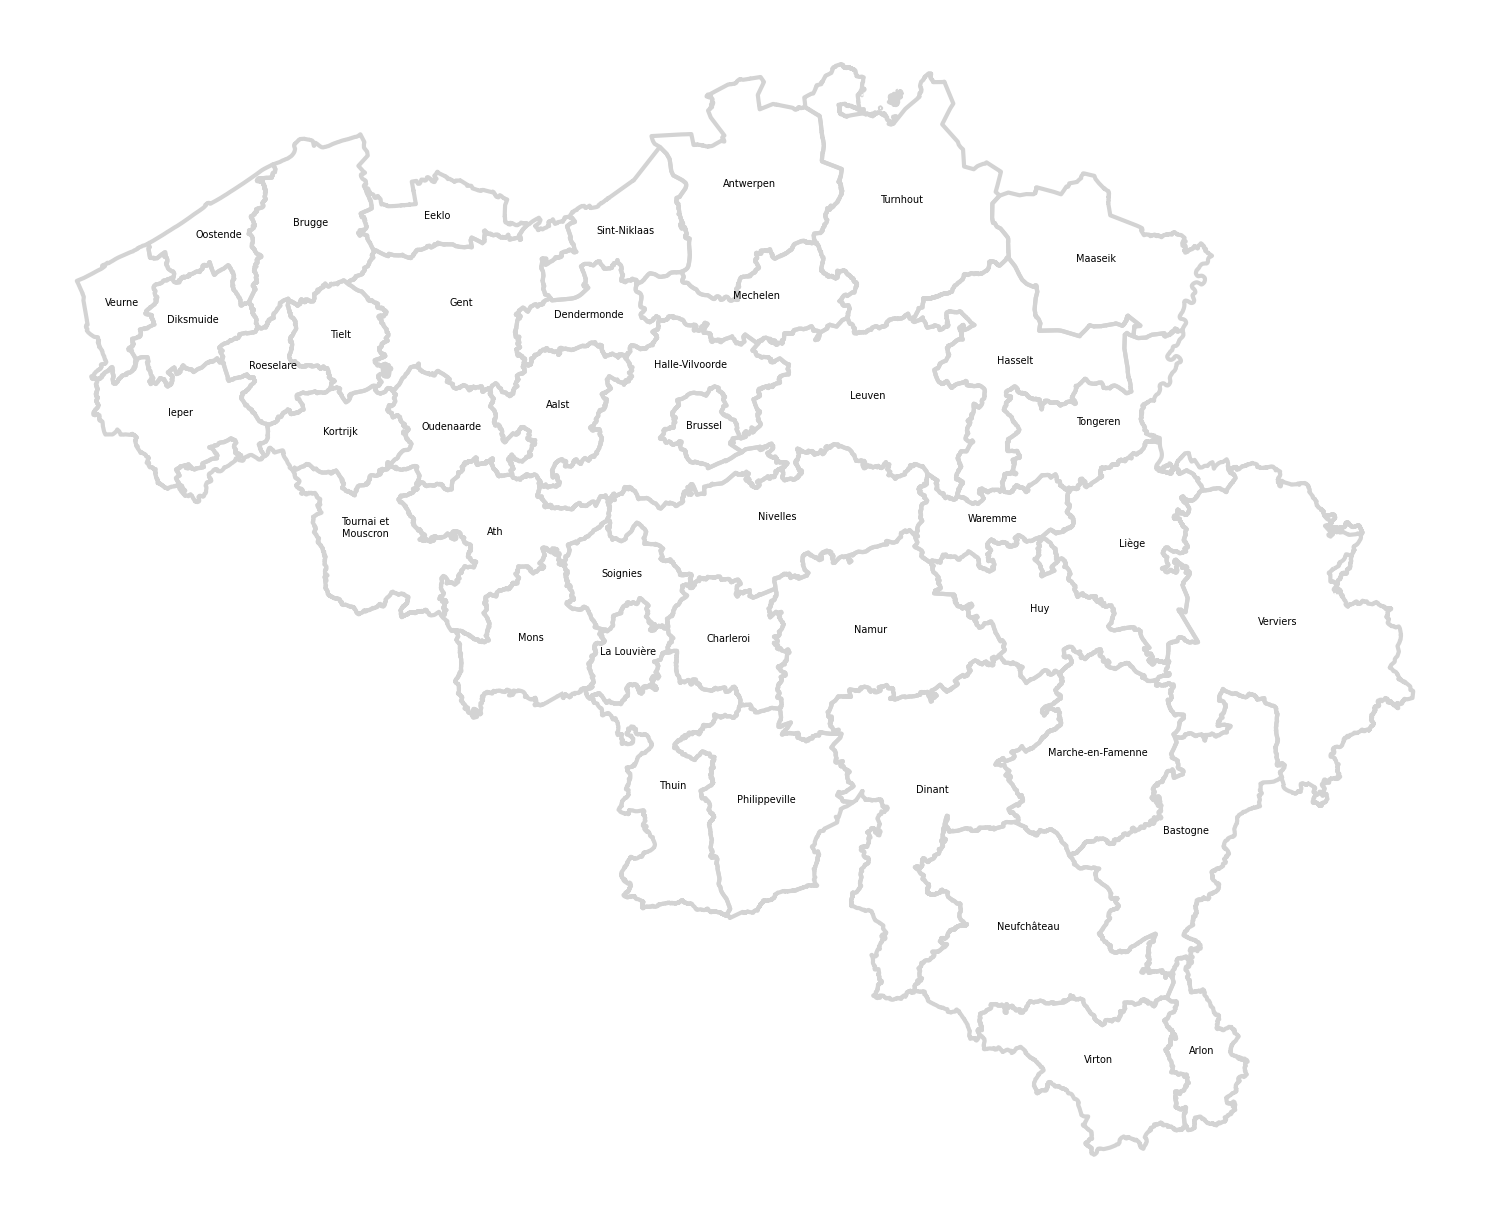

In [10]:
################################################
# 1. PLOTTING THE DISTRICTS OF BELGIUM #
################################################

#### Loading the spatial data for Belgian districts
arrondissements = gpd.read_file('/home/rita/PyProjects/Practice/Geopandas shape files Tijs Belgium/shape_BE/shape_files/AD_3_District.shp')

arrondissements['NameLocal'] = None
NIS_to_local_dict = dict({'11000' : 'Antwerpen',
                          '12000' : 'Mechelen',
                          '13000' : 'Turnhout',
                          '21000' : 'Brussel',
                          '23000' : None, # 'Halle-Vilvoorde',
                          '24000' : 'Leuven',
                          '25000' : 'Nivelles',
                          '31000' : 'Brugge',
                          '32000' : 'Diksmuide',
                          '33000' : 'Ieper',
                          '34000' : 'Kortrijk',
                          '35000' : 'Oostende',
                          '36000' : 'Roeselare',
                          '37000' : 'Tielt',
                          '38000' : 'Veurne',
                          '41000' : 'Aalst',
                          '42000' : 'Dendermonde',
                          '43000' : 'Eeklo',
                          '44000' : 'Gent',
                          '45000' : 'Oudenaarde',
                          '46000' : 'Sint-Niklaas',
                          '51000' : 'Ath',
                          '52000' : 'Charleroi',
                          '53000' : 'Mons',
                          '55000' : 'Soignies',
                          '56000' : 'Thuin',
                          '57000' : '\nTournai et\nMouscron',
                          '58000' : 'La Louvière',
                          '61000' : 'Huy',
                          '62000' : 'Liège',
                          '63000' : 'Verviers',
                          '64000' : 'Waremme',
                          '71000' : 'Hasselt',
                          '72000' : 'Maaseik',
                          '73000' : 'Tongeren',
                          '81000' : 'Arlon',
                          '82000' : 'Bastogne',
                          '83000' : 'Marche-en-Famenne',
                          '84000' : 'Neufchâteau',
                          '85000' : 'Virton',
                          '91000' : 'Dinant',
                          '92000' : 'Namur',
                          '93000' : 'Philippeville',
                         })
for nis, name in NIS_to_local_dict.items():
    arrondissements.loc[arrondissements['NISCode']==nis,'NameLocal'] = name

## plotting the data
fig,ax = plt.subplots(figsize=(15,15))
ax.axis('off')

# Shapes
arrondissements.plot(ax=ax, facecolor="none", edgecolor="lightgrey", linewidth=3)
# Text arrondissements
arrondissements.apply(lambda x: ax.annotate(text=x['NameLocal'], xy=x.geometry.centroid.coords[0], ha='center', size=7, color='k'), axis=1)
ax.text(640000, 682000, 'Halle-Vilvoorde', size=7)

plt.tight_layout()

plt.savefig('/home/rita/PyProjects/DI-MOB-BionamiX/results/DENV_model/map-of-belgian-arrondissements.pdf', dpi=800, bbox_inches='tight')


In [11]:
################################################
# 2. ADDING THE MODELLED DENV INFECTIONS #
################################################

## merging my output to my shapefile by NIS codes - attribute join
# print(arrondissements)

# Perform a join or merge operation based on different column names
# print("Structure model output: ", str(out))
# print("Structure spatial data: ", str(arrondissements))

# print("Type model output: ", type(out))             #<class 'xarray.core.dataset.Dataset'>
# print("Type spatial data: ", type(arrondissements)) #<class 'geopandas.geodataframe.GeoDataFrame'>
model_output_df = out.to_dataframe()
model_output_df.reset_index(inplace=True)           # This sets the xarray dimensions to columns, so that we can use them later on
# print("Type model output: ", type(model_output_df)) # <class 'pandas.core.frame.DataFrame'>

# print(model_output_df.head())
# print(arrondissements.head())

## merging not working, let's verify the datatypes of NISCode in arrondissements match those in NIS model_output_df
# print("datatypes arrodissements", arrondissements.dtypes)
# print("datatypes model outputs", model_output_df.dtypes) # NISCode in arrondissements is an object, won't work for merge

# Convert attribute to string in GeoDataFrame
arrondissements['NISCode'] = pd.to_numeric(arrondissements['NISCode'], errors='coerce').astype('Int64')

model_with_map = arrondissements.merge(model_output_df, left_on ='NISCode', right_on = "NIS")
print("merged dataframe inspection", model_with_map.head())
print(model_with_map["age_group"].unique())

merged dataframe inspection     ModifDate  NISCode                                    tgid     Shape_Leng  \
0  2007-01-05    81000  {3E0FC3C6-1C73-48A2-83D1-7DC3A7AA8514}  138306.528302   
1  2007-01-05    81000  {3E0FC3C6-1C73-48A2-83D1-7DC3A7AA8514}  138306.528302   
2  2007-01-05    81000  {3E0FC3C6-1C73-48A2-83D1-7DC3A7AA8514}  138306.528302   
3  2007-01-05    81000  {3E0FC3C6-1C73-48A2-83D1-7DC3A7AA8514}  138306.528302   
4  2007-01-05    81000  {3E0FC3C6-1C73-48A2-83D1-7DC3A7AA8514}  138306.528302   

     Shape_Area NameDut NameFre NameGer  \
0  3.188733e+08    None   Arlon    None   
1  3.188733e+08    None   Arlon    None   
2  3.188733e+08    None   Arlon    None   
3  3.188733e+08    None   Arlon    None   
4  3.188733e+08    None   Arlon    None   

                                            geometry NameLocal  ...  E12  E21  \
0  POLYGON Z ((750399.997 528112.712 0.000, 75045...     Arlon  ...  0.0  0.0   
1  POLYGON Z ((750399.997 528112.712 0.000, 75045...     Arlon  

Plotting the results from the merged dataframe

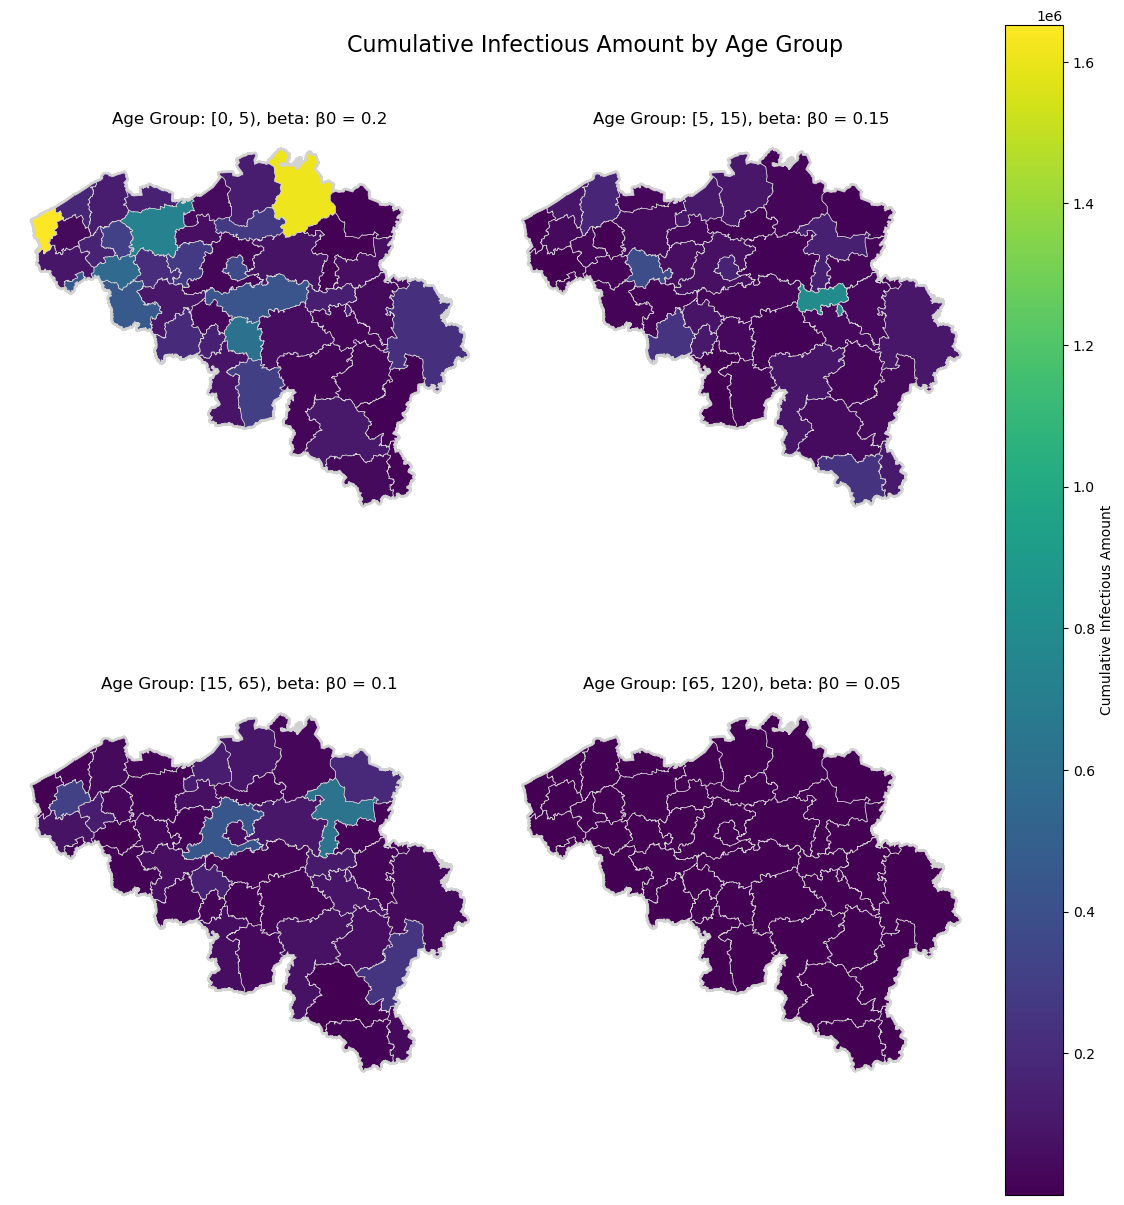

In [43]:
## plotting the cummulative infectious amount of individuals at the end of the 5 year per location with a subplot per age group

age_groups = model_with_map['age_group'].unique()
midpoints = [interval.mid for interval in age_groups]
model_with_map_t1825 = model_with_map[model_with_map['time'] == 1825]


fig, axs = plt.subplots(2,2, figsize = (12,12))

# Initialize legend
handles = []
mappable = None

# Initialize min and max values
overall_min = model_with_map_t1825['I_cum'].min()
overall_max = model_with_map_t1825['I_cum'].max()

i=0
for ax, age_group_midpoint in zip(axs.flat, midpoints):# we need to use midpoint values because you cannot iterate over intervals

    #filter dataset for current age_group
    # subset = model_with_map[model_with_map['age_group'] == 'age_group']
    subset = model_with_map_t1825[model_with_map_t1825['age_group'].apply(lambda x: x.mid) == age_group_midpoint]
    
    #################################
    # Plot arrondissement boundaries
    #################################

    model_with_map_t1825.plot(ax=ax, facecolor="none", edgecolor="lightgrey", linewidth=3)
    # # Add annotations for arrondissement names
    # for idx, row in model_with_map_t1825.iterrows():
    #     ax.annotate(text=row['NameLocal'], xy=row.geometry.centroid.coords[0], ha='center', size=7, color='k')
    
    #####################
    # Plot model results
    #####################

    # Plot GeoDataFrame with colors based on 'I_cum' values
    # subset.plot(ax=ax, column='I_cum', cmap='viridis', edgecolor="lightgrey", linewidth=3, legend=True)
    handle = subset.plot(ax=ax, column='I_cum', cmap='viridis', edgecolor="lightgrey", linewidth=0.5, legend=False, vmin=overall_min, vmax=overall_max)

    # Store the mappable object
    mappable = handle.get_children()[0]

    # Add the handle to the legend
    handles.append(handle.collections[0])

    # add a title for the subplot
    ax.set_title(f'Age Group: {age_groups[i]}, beta: \u03B20 = {params["beta_0"][i]}')
    i = i+1
    #remove axis
    ax.axis("off")


# # Create a single legend for all subplots
# fig.legend(handles, labels=midpoints, loc='upper right', title='Age Groups')

# adjust layout 
plt.tight_layout()

# Add a single title above the subplots
plt.suptitle('Cumulative Infectious Amount by Age Group', fontsize=16)

# Create a ScalarMappable object
sm = ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=overall_min, vmax=overall_max))

# Create colorbar using the ScalarMappable object
colorbar = plt.colorbar(sm, ax=axs, label='Cumulative Infectious Amount', orientation='vertical', pad=0.02)

fig1 = plt.gcf() # get current figure (otherwise my pdf was coming up blank)

plt.show()

fig1.savefig('/home/rita/PyProjects/DI-MOB-BionamiX/results/DENV_model/map-of-DENV-per-arrondissements.pdf')


Now I want to create the same plot but then normalized by dividing by the initial population counts for every group in every location. 

    ModifDate  NISCode                                    tgid     Shape_Leng  \
0  2007-01-05    81000  {3E0FC3C6-1C73-48A2-83D1-7DC3A7AA8514}  138306.528302   
1  2007-01-05    81000  {3E0FC3C6-1C73-48A2-83D1-7DC3A7AA8514}  138306.528302   
2  2007-01-05    81000  {3E0FC3C6-1C73-48A2-83D1-7DC3A7AA8514}  138306.528302   
3  2007-01-05    81000  {3E0FC3C6-1C73-48A2-83D1-7DC3A7AA8514}  138306.528302   
4  2007-01-05    81000  {3E0FC3C6-1C73-48A2-83D1-7DC3A7AA8514}  138306.528302   

     Shape_Area NameDut NameFre NameGer  \
0  3.188733e+08    None   Arlon    None   
1  3.188733e+08    None   Arlon    None   
2  3.188733e+08    None   Arlon    None   
3  3.188733e+08    None   Arlon    None   
4  3.188733e+08    None   Arlon    None   

                                            geometry NameLocal  ...  E21  \
0  POLYGON Z ((750399.997 528112.712 0.000, 75045...     Arlon  ...  0.0   
1  POLYGON Z ((750399.997 528112.712 0.000, 75045...     Arlon  ...  0.0   
2  POLYGON Z ((750399.997 

/home/rita/anaconda3/envs/PYSODM/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_8126/1331426532.py:69: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(handles, labels=midpoints, loc='upper right', title='Age Groups')


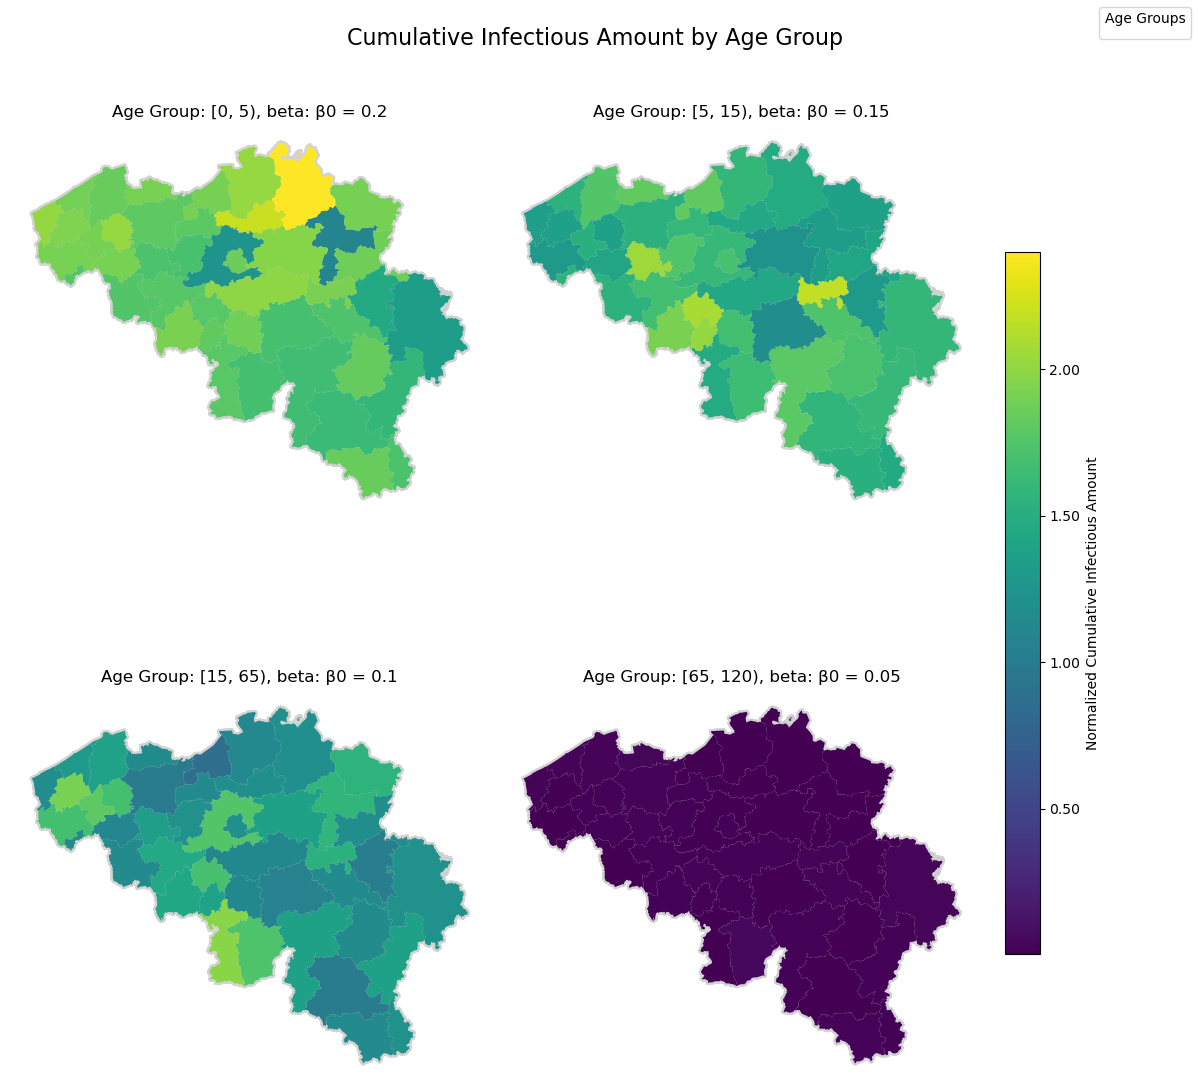

In [42]:
import matplotlib.cm as cm

# I will first merge initN with the model_with_map
initN_dataFrame = pd.DataFrame(initN)

model_with_map_initN = model_with_map.merge(initN_dataFrame, left_on=['NISCode', 'age_group'], right_on=['NIS', 'age_group'])
print(model_with_map_initN.head())
model_with_map_initN = model_with_map_initN.rename(columns={0: 'initN'})
print(model_with_map_initN["initN"].count()) #counting the number of not-missings = 314072 --> number of rows in model_with_map --> OK

age_groups = model_with_map_initN['age_group'].unique()
midpoints = [interval.mid for interval in age_groups]
model_with_map_initN_t1825 = model_with_map_initN[model_with_map_initN['time'] == 1825]

fig, axs = plt.subplots(2,2, figsize = (12,12))

# Initialize legend
handles = []
mappable = None

# Calculate the overall minimum and maximum values of the quotient across all age groups

model_with_map_initN_t1825['normalized_I_cum'] = model_with_map_initN_t1825['I_cum'] / model_with_map_initN_t1825['initN']
overall_min = model_with_map_initN_t1825['normalized_I_cum'].min() # 0.002445912342510767
overall_max = model_with_map_initN_t1825['normalized_I_cum'].max() # 2.451375314564849

i = 0
for ax, age_group_midpoint in zip(axs.flat, midpoints):# we need to use midpoint values because you cannot iterate over intervals

    #filter dataset for current age_group
    # subset = model_with_map[model_with_map['age_group'] == 'age_group']
    subset = model_with_map_initN_t1825[model_with_map_initN_t1825['age_group'].apply(lambda x: x.mid) == age_group_midpoint]
    
    #################################
    # Plot arrondissement boundaries
    #################################

    model_with_map_initN_t1825.plot(ax=ax, facecolor="none", edgecolor="lightgrey", linewidth=3)
    # # Add annotations for arrondissement names
    # for idx, row in model_with_map_t1825.iterrows():
    #     ax.annotate(text=row['NameLocal'], xy=row.geometry.centroid.coords[0], ha='center', size=7, color='k')
    
    #####################
    # Plot model results
    #####################

    # Plot model results for the current age group
    handle = subset.plot(ax=ax, column="normalized_I_cum", cmap='viridis', vmin=overall_min, vmax=overall_max, legend=False)


    # Plot GeoDataFrame with colors based on 'I_cum' values
    # subset.plot(ax=ax, column='I_cum', cmap='viridis', edgecolor="lightgrey", linewidth=3, legend=True)
    # handle = subset.plot(ax=ax, column='I_cum'/"initN", cmap='viridis', edgecolor="lightgrey", linewidth=0.5, legend=False, vmin=overall_min, vmax=overall_max)

    # Store the mappable object
    mappable = handle.get_children()[0]

    # Add the handle to the legend
    handles.append(handle.collections[0])

    # add a title for the subplot
    ax.set_title(f'Age Group: {age_groups[i]}, beta: \u03B20 = {params["beta_0"][i]}')
    i = i+1
    #remove axis
    ax.axis("off")


# Create a single legend for all subplots
fig.legend(handles, labels=midpoints, loc='upper right', title='Age Groups')

# adjust layout 
plt.tight_layout()

# Add a single title above the subplots
plt.suptitle('Cumulative Infectious Amount by Age Group', fontsize=16)


# Get the overall min and max of normalized values
# overall_min = merged_data['normalized_I_cum'].min()
# overall_max = merged_data['normalized_I_cum'].max()

# Create a single colorbar for all subplots
# cbar = plt.colorbar(ax=axs.ravel().tolist()[0].collections[0], orientation='vertical', pad=0.02, shrink=0.6, format='%.2f')

# cbar.set_label('Normalized Cumulative Infectious Amount')

sm = cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=overall_min, vmax=overall_max))
sm.set_array([])
cbar = plt.colorbar(sm, ax=axs, orientation='vertical', pad=0.02, shrink=0.6, format='%.2f')
cbar.set_label('Normalized Cumulative Infectious Amount')

fig1 = plt.gcf() # get current figure (otherwise my pdf was coming up blank)

plt.show()

fig1.savefig('/home/rita/PyProjects/DI-MOB-BionamiX/results/DENV_model/map-of-DENV-per-arrondissements-normalized.pdf', dpi=800, bbox_inches='tight')


/home/rita/anaconda3/envs/PYSODM/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


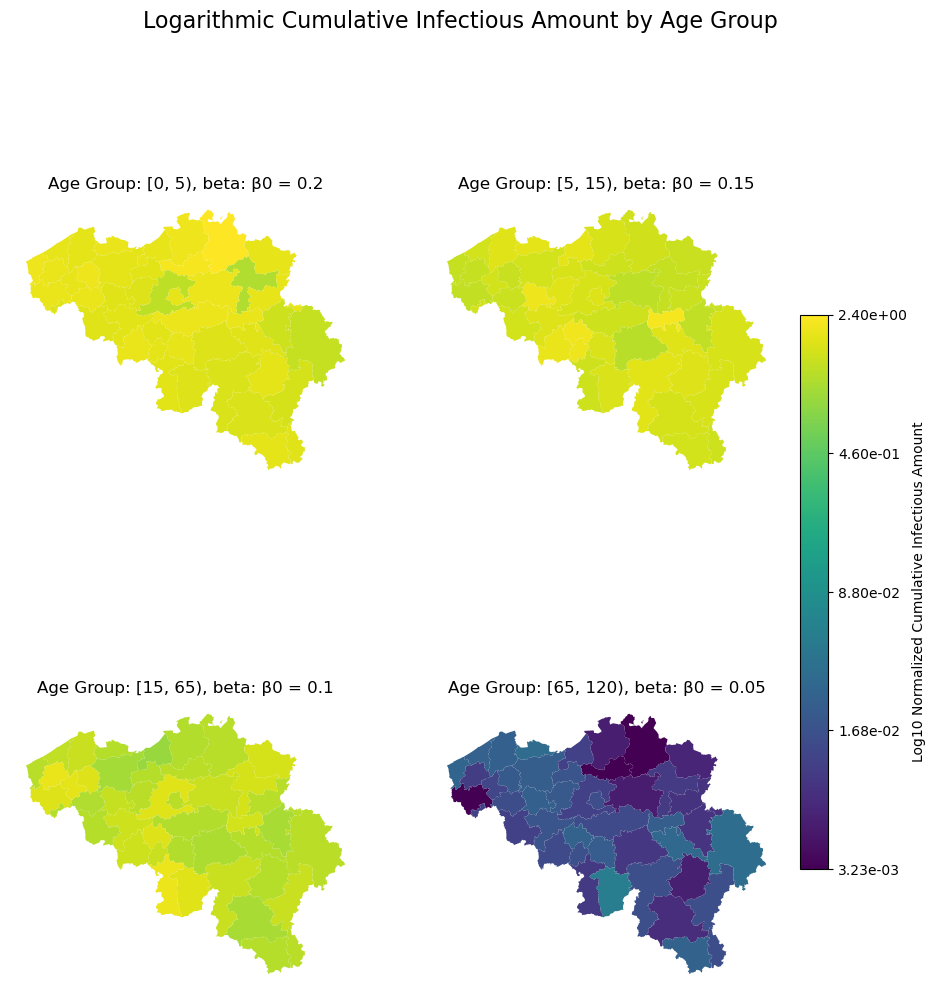

In [41]:
## LOGARITHMIC NORMALIZED CUMULATIVE INCIDENCE PER AGE GROUP

# Calculate the overall minimum and maximum values of the quotient across all age groups
model_with_map_initN_t1825['normalized_I_cum'] = model_with_map_initN_t1825['I_cum'] / model_with_map_initN_t1825['initN']
model_with_map_initN_t1825['log_normalized_I_cum'] = np.log10(model_with_map_initN_t1825['normalized_I_cum'])

# Calculate the overall minimum and maximum values of the logarithmic values across all age groups
log_overall_min = model_with_map_initN_t1825['log_normalized_I_cum'].min()
log_overall_max = model_with_map_initN_t1825['log_normalized_I_cum'].max()

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot each age group
i = 0
for ax, age_group_midpoint in zip(axs.flat, midpoints):
    subset = model_with_map_initN_t1825[model_with_map_initN_t1825['age_group'].apply(lambda x: x.mid) == age_group_midpoint]

    # Plot GeoDataFrame with colors based on the logarithmic values
    handle = subset.plot(ax=ax, column="log_normalized_I_cum", cmap='viridis', vmin=log_overall_min, vmax=log_overall_max, legend=False)

    # Set title for the subplot
    ax.set_title(f'Age Group: {age_groups[i]}, beta: \u03B20 = {params["beta_0"][i]}')
    i = i+1
    # Remove axis
    ax.axis("off")

# Create a single colorbar for all subplots using ScalarMappable
sm = cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=log_overall_min, vmax=log_overall_max))
sm.set_array([])
cbar = plt.colorbar(sm, ax=axs, orientation='vertical', pad=0.02, shrink=0.6)
cbar.set_label('Log10 Normalized Cumulative Infectious Amount')

# Calculate colorbar ticks and labels
tick_values = np.linspace(log_overall_min, log_overall_max, num=5)
cbar.set_ticks(tick_values)
cbar.set_ticklabels([f'{10**tick:.2e}' for tick in tick_values])

# Add a single title above the subplots
plt.suptitle('Logarithmic Cumulative Infectious Amount by Age Group', fontsize=16)


fig1 = plt.gcf() # get current figure (otherwise my pdf was coming up blank)

plt.show()

fig1.savefig('/home/rita/PyProjects/DI-MOB-BionamiX/results/DENV_model/map-of-DENV-per-arrondissements-LogNormalized.pdf', dpi=800, bbox_inches='tight')


In [18]:
print(age_groups[1])

[5, 15)


In [39]:
for ax, age_group_midpoint in zip(axs.flat, midpoints):
    print(ax)

print(params["beta_0"][0])
print("beta: \u03B20")

Axes(0.0125,0.572529;0.399438x0.325853)
Axes(0.422313,0.572529;0.399438x0.325853)
Axes(0.0125,0.101618;0.399438x0.325853)
Axes(0.422313,0.101618;0.399438x0.325853)
0.2
beta: β0
